## CS454-Hw1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_set = pd.read_csv("training.csv")
test_set = pd.read_csv("testing.csv")

In [3]:
total_set = pd.concat([train_set, test_set], ignore_index = True, axis = 0)
total_set

,age,class
0,24,1
1,21,1
2,26,1
3,27,1
4,28,1
...,...,...
295,56,3
296,53,3
297,44,3
298,47,3


In [4]:
total_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     300 non-null    int64
 1   class   300 non-null    int64
dtypes: int64(2)
memory usage: 4.8 KB


In [5]:
train_set.shape

(150, 2)

In [6]:
train_set.shape

(150, 2)

In [7]:
classes = train_set["class"].unique()
classes

array([1, 2, 3], dtype=int64)

<AxesSubplot:title={'center':'Age distribution'}, xlabel='age', ylabel='Count'>

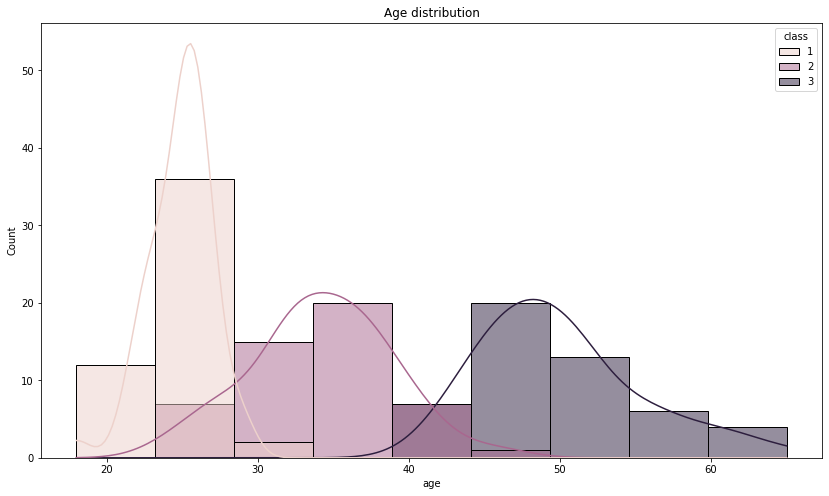

In [8]:
plt.figure(figsize=(14,8))
plt.title("Age distribution")
sns.histplot(test_set, x="age", hue="class", kde =True)

In [9]:
def prior():
    tot_len = len(train_set)
    class_len = {}
    
    for c in classes:
        class_len[c] = 0
        
    for i in range(len(train_set)):
        for c in classes:
            if train_set["class"].iloc[i] == c:
                class_len[c] += 1
                
    prior_vec = np.array(list(class_len.values())) / tot_len
    return prior_vec

In [10]:
prior()

array([0.33333333, 0.33333333, 0.33333333])

In [11]:
def mean():
    class_sum = {}
    class_len = {}
    
    for c in classes:
        class_sum[c] = 0
        class_len[c] = 0
    
    for i in range(len(train_set)):
        for c in classes:
            if train_set["class"].iloc[i] == c:
                class_sum[c] += train_set["age"].iloc[i]
                class_len[c] += 1
    
    mean_vec = np.array(list(class_sum.values())) / np.array(list(class_len.values()))
    return mean_vec

In [12]:
mean()

array([24.48, 34.12, 49.44])

In [13]:
def std():
    sum_diff2 = {}
    class_len = {}
 
    for c in classes:
        sum_diff2[c] = 0
        class_len[c] = 0
        
    mean_vec = mean()
    
    for i in range(len(train_set)):
        for c in classes:
            if train_set["class"].iloc[i] == c:
                sum_diff2[c] += (train_set["age"].iloc[i] - mean_vec[np.where(classes == c)[0][0]]) ** 2
                class_len[c] += 1
                
    std_vec = np.sqrt(np.array(list(sum_diff2.values())) / np.array(list(class_len.values())))
    return std_vec

In [14]:
std()

array([1.9923855 , 4.13589168, 5.09179733])

In [15]:
prior_vec = prior()
mean_vec = mean()
std_vec = std()
k = 0
for c in classes:
    print("Class {} Prior: {}".format(c, prior_vec[k]))
    print("Class {} Mean : {}".format(c, mean_vec[k]))
    print("Class {} Std  : {}".format(c, std_vec[k]))
    print("-"*35)
    k += 1

Class 1 Prior: 0.3333333333333333
Class 1 Mean : 24.48
Class 1 Std  : 1.992385504865963
-----------------------------------
Class 2 Prior: 0.3333333333333333
Class 2 Mean : 34.12
Class 2 Std  : 4.1358916813669095
-----------------------------------
Class 3 Prior: 0.3333333333333333
Class 3 Mean : 49.44
Class 3 Std  : 5.091797325110258
-----------------------------------


In [16]:
def likelihood(x): 
    mean_vec = mean()
    std_vec = std()
    likelihood_vec = (1 / (std_vec * np.sqrt(2*np.pi))) * (np.exp(-1/2 * ((x - mean_vec) / std_vec) ** 2))
                                               
    return likelihood_vec

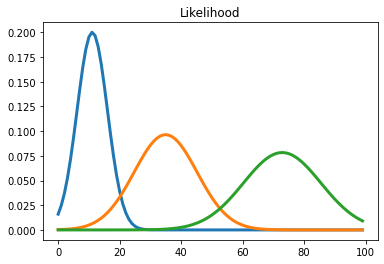

In [17]:
ll = []
age_sample = np.linspace(train_set["age"].min(), train_set["age"].max(), 100, endpoint=True)
for age in age_sample:
    ll.append(likelihood(age))
plt.title("Likelihood")
plt.plot(ll, linewidth = 3)

In [18]:
def posteriors(x):
    """
    P(X|C) * P(C) / P(X)
    """
    
    prior_vec = prior()
    likelihood_vec = likelihood(x)
    
    posteriors_num = {}
    for c in classes:
        posteriors_num[c] = 0
        
    for c in classes:
        posteriors_num[c] = (likelihood_vec[np.where(classes == c)[0][0]]) * (prior_vec[np.where(classes == c)[0][0]])
                
    posteriors_dem = 0
    posteriors_num = list(posteriors_num.values())
    for num in posteriors_num:
        posteriors_dem += num
        
    post_list = posteriors_num / posteriors_dem
    return post_list

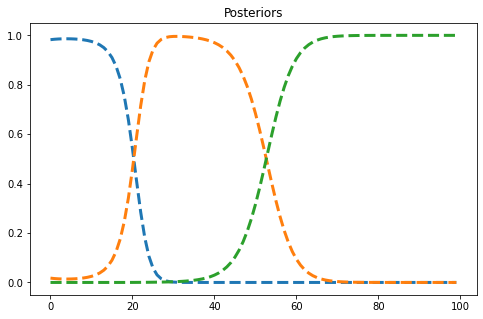

In [19]:
pl = []
age_sample = np.linspace(train_set["age"].min(), train_set["age"].max(), 100, endpoint=True)
for age in age_sample:
    pl.append(posteriors(age))

plt.figure(figsize=(8,5))
plt.title("Posteriors")
plt.plot(pl ,"--", linewidth = 3)

In [20]:
def risk(x):
    posteriors_vec = posteriors(x)
    """
    Assuming that 
        Cost (loss) of assigning an input to a wrong class is 4
        Cost of rejecting an instance is 1
        
        
        Loss Table:
                     Truth
        Action   |C=1|C=2|C=3|
        Action 1 | 0 | 4 | 4 |
        Action 2 | 4 | 0 | 4 |
        Action 3 | 4 | 4 | 0 |
        Action r | 1 | 1 | 1 | (Reject case)
        
        R(a1|X) = 0 * P(C=1|X) + 4 * P(C=2|X) + 4 * P(C=3|X)
                = 4 * (P(C=2|X) + P(C=3|X))
                = 4 * (1 - P(C=1|X))      Since P(C=1|X) + P(C=2|X) + P(C=3|X) is equal to 1
        
        R(a2|X) = 4 * P(C=1|X) + 0 * P(C=2|X) + 4 * P(C=3|X)
                = 4 * (P(C=1|X) + P(C=3|X))
                = 4 * (1 - P(C=2|X))
                
        R(a3|X) = 4 * P(C=1|X) + 4 * P(C=2|X) + 0 * P(C=3|X)
                = 4 * (P(C=1|X) + P(C=2|X))
                = 4 * (1 - P(C=3|X))
                
        R(ar|X) = 1 * P(C=1|X) + 1 * P(C=2|X) + 1 * P(C=3|X)
                = 1
        
        Risk vector => [4 * (1 - P(C=1|X)),
                        4 * (1 - P(C=2|X)),
                        4 * (1 - P(C=3|X)),
                        1]
    """

    
    
    risk_vec = []
    risk_reject = 1
    for i in range(len(posteriors_vec)):
        risk_vec.append(4 * (1 - posteriors_vec[i]))
    risk_vec.append(risk_reject)
    
    
    return risk_vec

In [21]:
def plot(data, title):

    likelihood_val = []
    posteriors_val = []
    age_sample = np.linspace(data["age"].min(), data["age"].max(), 100, endpoint=True)
    
    for age in age_sample:
        likelihood_val.append(likelihood(age))
        posteriors_val.append(posteriors(age))
        
    likelihood_val = np.array(likelihood_val)
    posteriors_val = np.array(posteriors_val)
    
    
    instances = {}
    for c in classes:
        instances[c] = []
    
    for i in range(len(data)):
        for c in classes:
            if(data["class"].iloc[i] == c):
                instances[c].append(data["age"].iloc[i])
    
    instances = np.array(list(instances.values()))
    
    instances_val = []
    val = 1
    for c in classes:
        instances_val.append(np.ones(len(data[data["class"] == c])) * (- (val) / 10))
        val += 1

    
    plt.figure(figsize=(14,8))
    
    if title == "train":
        plt.title("Likelihoods and Posteriors for Train Dataset")
    else:
        plt.title("Likelihoods and Posteriors for Test Dataset")
        
    
    plt.plot(age_sample,posteriors_val[:,:1], "--", linewidth = 3, color="red", label="P(C=1|X)")
    plt.plot(age_sample,posteriors_val[:,1:2], "--", linewidth = 3, color="green", label="P(C=2|X)")
    plt.plot(age_sample,posteriors_val[:,2:3], "--", linewidth = 3, color="blue", label="P(C=3|X)")
    
    plt.plot(age_sample,likelihood_val[:,:1], "-", linewidth = 3, color="red", label="P(X|C=1)")
    plt.plot(age_sample,likelihood_val[:,1:2], "-", linewidth = 3, color="green", label="P(X|C=2)")
    plt.plot(age_sample,likelihood_val[:,2:3], "-", linewidth = 3, color="blue",label="P(X|C=3)")
    
    plt.plot(instances[0],instances_val[0], "x", color="red", markersize=8)
    plt.plot(instances[1],instances_val[1], "o", color="green", markersize=8)
    plt.plot(instances[2],instances_val[2], "*", color="blue", markersize=8)
    
    plt.legend()
    plt.show()

In [22]:
def accuracy(pred, real, title):
    if title == "train" or title == "train_reject":
        title = "Train Dataset"
    elif title == "test" or title == "test_reject":
        title = "Test Dataset"
    
    sum = 0
    for i in range(len(test_set)):
        if(pred[i] != real[i]):
            sum += 1
    print(" " *3," Accuracy for", title,": ",(len(test_set) -sum) /len(test_set))

In [23]:
def confusion_matrix(pred, real, title):
        
    data = {'y_Predicted': pred,
            'y_Actual':    real
            }
    df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
   
    confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Predicted'], colnames=['Actual'])
    
    plt.figure(figsize=(6,4))
    if title == "train":
        plt.title("0/1 Loss Confusion Matrix for Train Dataset")
    elif title == "test":
        plt.title("0/1 Loss Confusion Matrix for Test Dataset")
    elif title == "train_reject":
        plt.title("Costed Loss Confusion Matrix for Train Dataset")
    else:
        plt.title("Costed Loss Confusion Matrix for Test Dataset")
        
    sns.heatmap(confusion_matrix, annot=True, cmap="plasma")
    plt.show()

In [24]:
def info(pred, real, title):
    print("* * * " * 20, "\n")
    accuracy(pred, real, title)
    confusion_matrix(pred, real, title)

In [25]:
def model_01(train, test):
    real_val_train = train["class"].values
    real_val_test = test["class"].values
    pred_val_train = []
    pred_val_test = []
    
    for i in range(len(train)):
        pred_val_train.append(classes[posteriors(train["age"].iloc[i]).argmax()])
        pred_val_test.append(classes[posteriors(test["age"].iloc[i]).argmax()])  
        
    info(pred_val_train, real_val_train, "train")
    info(pred_val_test, real_val_test, "test") 

In [26]:
def predict_reject(data, title):
    """
    Choose Action1, check R1 < R2 and R1 < R3 and R1 < R4(reject) for acceptance
        
        - R1 < R2 => 4 * (1 - P(C=1|X)) < 4 * (1 - P(C=2|X))
                  =  P(C=1|X) > P(C=2|X)
        
        - R1 < R3 => 4 * (1 - P(C=1|X)) < 4 * (1 - P(C=3|X))
                  =  P(C=1|X) > P(C=3|X)
                  
        - R1 < Rr => 4 * (1 - P(C=1|X)) < 1
                  =  P(C=1|X) > 3/4
                  
                  
        So, we can mathematically say that 
        
        Accept if     
            P(C|X) for the specified class is greater than 0.75 and greater than other posteriors for given X
        Otherwise 
            Reject it
            
    """
    real_val = data["class"].values
    pred_val = []
    
    posteriors_mat = []
    for i in range(len(data)):
        posteriors_mat.append(posteriors(data["age"].iloc[i]))
    
    for post in posteriors_mat:
        if ((post[0] > post[1]) and (post[0] > post[2]) and (post[0] > 0.75)):
            pred_val.append(classes[0])
        elif (post[1] > post[0]) and (post[1] > post[2]) and (post[1] > 0.75):
            pred_val.append(classes[1])
        elif (post[2] > post[0]) and (post[2] > post[1]) and (post[2] > 0.75):
            pred_val.append(classes[2])
        else:
            pred_val.append("#Reject")                                                                                                                                                                                                                      
    info(pred_val, real_val, title) 

In [27]:
def model_reject(train,test):
    predict_reject(train, "train_reject")
    predict_reject(test, "test_reject")

In [28]:
def model(train, test):
    plot(train,"train")
    plot(test,"test")
    model_01(train, test)
    model_reject(train,test)

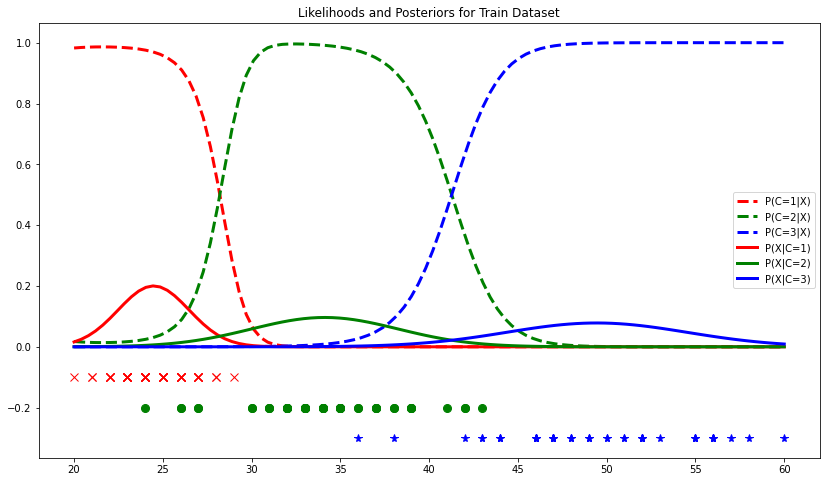

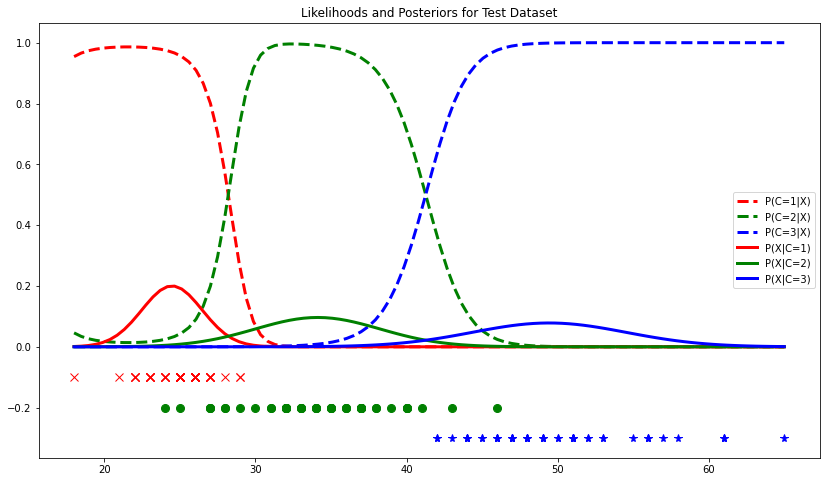

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *  

     Accuracy for Train Dataset :  0.9266666666666666


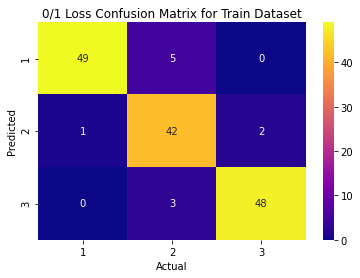

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *  

     Accuracy for Test Dataset :  0.9266666666666666


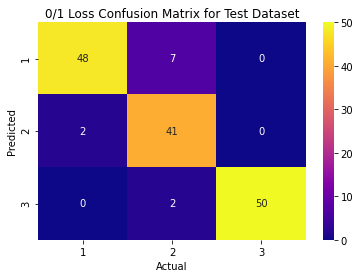

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *  

     Accuracy for Train Dataset :  0.9


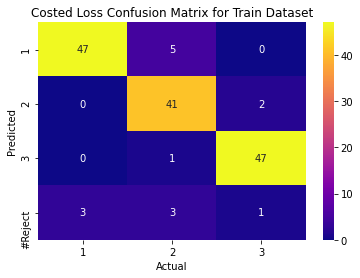

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *  

     Accuracy for Test Dataset :  0.8666666666666667


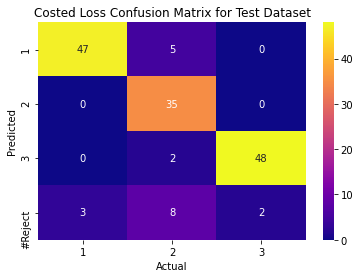

In [29]:
model(train_set,test_set)